In [12]:
import pandas as pd
import os
import numpy as np
import csv
from matplotlib import pyplot as plt

import pydicom
import glob
import natsort
import cv2

import scipy.ndimage
from skimage import measure, morphology
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from sklearn.model_selection import train_test_split

import pickle

# EDA on MRI Image Data With T2 Scans

Looking through mri_df

In [13]:
def make_dict(ext, ids):
    # mapping of filepaths --> dcm files
    dcm_dict = {}
    PathDicom = "../ppmi/cd-pd/"
    for dirName, subdirList, fileList in os.walk(PathDicom):
        files = []
        for filename in fileList:
            if ext in filename.lower():  # check whether the file's DICOM
                files.append(os.path.join(dirName,filename))
        if len(files) > 0 and int(dirName.split('/')[4]) in ids and 'T2' in dirName:
            dcm_dict[dirName] = files
                
    return dcm_dict

In [14]:
def make_stage_dict(df, d):
    # mapping of subject --> filepaths --> dcm files
    dcm_dict = {}
    ids = set(df['Subject'])
    keys = list(d)
    for i in ids:
        id_list = {}
        for k in keys:
            if str(i) in k and 'T2' in k:
                id_list[k] = d[k]
        dcm_dict[i] = id_list
    
    return dcm_dict

In [15]:
mri_df = pd.read_csv('../ppmi/cd-pd/mri_t2_progression2.csv')
mri_df.head(10)

,Unnamed: 0,Image Data ID,Subject,Group,Sex,Age,Visit,Modality,Description,Type,Acq Date,Format,Downloaded,Progression,Stage
0,3,406544,3817,Control,M,75,0,MRI,T2 in T1-anatomical space,Processed,1/15/2013,NiFTI,NaN,0,0
1,10,410941,3816,Control,M,66,0,MRI,T2 in T1-anatomical space,Processed,12/04/2012,NiFTI,NaN,0,0
2,26,344402,3813,Control,M,66,0,MRI,Axial PD-T2 TSE,Original,10/16/2012,DCM,NaN,0,0
3,27,410769,3816,Control,M,66,0,MRI,T2 in corrected EPI space for I357776,Processed,12/04/2012,NiFTI,5/07/2019,0,0
4,32,357775,3816,Control,M,66,0,MRI,Axial PD-T2 TSE,Original,12/04/2012,DCM,NaN,0,0
5,35,362628,3817,Control,M,75,0,MRI,Axial PD-T2 TSE,Original,1/15/2013,DCM,NaN,0,0
6,38,344405,3813,Control,M,66,0,MRI,Axial PD-T2 TSE,Original,10/16/2012,DCM,NaN,0,0
7,39,357777,3816,Control,M,66,0,MRI,Axial PD-T2 TSE,Original,12/04/2012,DCM,NaN,0,0
8,40,410536,3813,Control,M,66,0,MRI,T2 in corrected EPI space for I344404,Processed,10/16/2012,NiFTI,NaN,0,0
9,44,370983,3813,Control,M,66,0,MRI,T2 in T1-anatomical space,Processed,10/16/2012,NiFTI,NaN,0,0


In [16]:
def patients_hist(group):
    group_df = mri_df[mri_df['Group'] == group]
    group_df.head(10)


    ids = set(group_df['Subject'])
    dates = []
    for i in ids:
        group_df_id = group_df[group_df['Subject'] == i]
        dates.append(len(set(group_df_id['Acq Date'])))

    # fixed bin size
    plt.xlim([0, 5])

    plt.hist(dates, bins=7, alpha=0.5)
    plt.title('Timepoints available for %s patients'%(group))
    plt.xlabel('number of timepoints')
    plt.ylabel('number of patients')

    plt.show()

In [17]:
len(set(mri_df['Subject']))

419

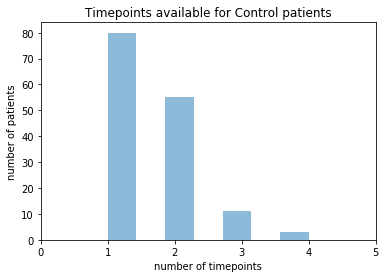

In [18]:
patients_hist('Control')

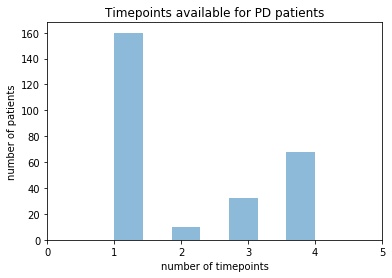

In [19]:
patients_hist('PD')

In [20]:
ages = mri_df['Age']
pd_df = mri_df[mri_df['Group']=='PD']
c_df = mri_df[mri_df['Group']=='Control']
pro_df = mri_df[mri_df['Group']=='Prodromal']

pd_f = len(set(pd_df[pd_df['Sex'] == 'F']['Subject']))
pd_m = len(set(pd_df[pd_df['Sex'] == 'M']['Subject']))
c_f = len(set(c_df[c_df['Sex'] == 'F']['Subject']))
c_m = len(set(c_df[c_df['Sex'] == 'M']['Subject']))
pro_f = len(set(pro_df[pro_df['Sex'] == 'F']['Subject']))
pro_m = len(set(pro_df[pro_df['Sex'] == 'M']['Subject']))

print('DATASET STATS')
print('AGE | Min: %d, Max: %d, Average; %d'%(min(ages), max(ages), sum(ages)/len(ages)))
print('GROUP | PD: %d, Control: %d, Prodromal: %d'%
      (len(set(pd_df['Subject'])), len(set(c_df['Subject'])), len(set(pro_df['Subject']))))
print('GENDER F | PD: %d, Contol: %d, Prodromdal: %d' %(pd_f, c_f, pro_f))
print('GENDER M | PD: %d, Contol: %d, Prodromdal: %d' %(pd_m, c_m, pro_m))

DATASET STATS
AGE | Min: 31, Max: 86, Average; 61
GROUP | PD: 270, Control: 149, Prodromal: 0
GENDER F | PD: 89, Contol: 53, Prodromdal: 0
GENDER M | PD: 181, Contol: 96, Prodromdal: 0


In [21]:
mri_df['Progression'].value_counts()

0    2232
1     449
Name: Progression, dtype: int64

In [22]:
mri_df['Group'].value_counts()

PD         1879
Control     802
Name: Group, dtype: int64

In [23]:
mri_df['Stage'].value_counts()

2    1053
1     825
0     799
3       4
Name: Stage, dtype: int64

In [24]:
mri_df['Sex'].value_counts()

M    1786
F     895
Name: Sex, dtype: int64

In [25]:
mri_df[mri_df['Stage'] == 3]

,Unnamed: 0,Image Data ID,Subject,Group,Sex,Age,Visit,Modality,Description,Type,Acq Date,Format,Downloaded,Progression,Stage
19,90,249476,3612,PD,M,68,1,MRI,AX PD + T2,Original,6/15/2011,DCM,NaN,0,3
974,2329,243283,3607,PD,F,55,1,MRI,AX PD + T2,Original,4/26/2011,DCM,NaN,0,3
1145,2744,249475,3612,PD,M,68,1,MRI,AX PD + T2,Original,6/15/2011,DCM,NaN,0,3
1219,2881,243285,3607,PD,F,55,1,MRI,AX PD + T2,Original,4/26/2011,DCM,NaN,0,3


In [26]:
len(pd_df), len(c_df)

(1879, 802)

In [27]:
stage0 = mri_df[mri_df['Stage'] == 0]
stage1 = mri_df[mri_df['Stage'] == 1]
stage2 = mri_df[mri_df['Stage'] == 2]
stage3 = mri_df[mri_df['Stage'] == 3]

In [28]:
len(stage0), len(stage1), len(stage2), len(stage3)

(799, 825, 1053, 4)

In [29]:
ls = set(mri_df['Description'])

In [30]:
mri_df['Description'].value_counts()

Axial PD-T2 TSE FS                       526
T2 in T1-anatomical space                501
Axial PD-T2 TSE                          476
AX PD + T2                                60
sT2W/PD_TSE                               56
Axial PD-T2-FS TSE                        42
AX T2 DE                                  40
Axial PD-T2 TSE_AC/PC line                38
Ax PD /T2                                 36
AXIAL PD-T2 TSE FS                        32
AXIAL  T2  FSE                            28
PD-T2 DUAL AXIAL TSE                      28
Ax T2 FLAIR                               26
AX T2 FLAIR                               21
AXIAL FSE T2 FS                           21
AX FLAIR T2                               20
AX T2                                     19
*AX FSE T2                                17
AX T2 FLAIR 5/1                           17
Ax T2 FSE                                 16
AX T2 AC-PC line Entire Brain             16
T2W_FLAIR                                  5
T2W_TSE   

In [31]:
count = 0
for t in ls:
    if 'T2 in corrected' in t: count+=1
count

616

In [32]:
mri_df['Format'].value_counts()

DCM      1564
NiFTI    1117
Name: Format, dtype: int64

# Creating Dictionaries of Paths to DCM and NiFTI Images for all patients

In [33]:
subject_ids = mri_df['Subject'].unique()

In [34]:
dcm_dict = make_dict('.dcm', subject_ids)
nifti_dict = make_dict('.nii', subject_ids)

In [35]:
print('DCM ', len(dcm_dict))
print('NiFTI ', len(nifti_dict))

DCM  874
NiFTI  998


In [32]:
paths = {'paths': nifti_scans, 'y': nifti_ys}
with open('nifti_scans.pickle', 'wb') as handle:
    pickle.dump(paths, handle)
print(len(nifti_scans), len(nifti_ys))

NameError: name 'nifti_scans' is not defined

In [35]:
ids = []
types = []
for dirName in dcm_dict:
    ids.append(int(dirName.split('/')[4]))
    types.append(dirName.split('/')[5])

In [36]:
files = mri_df[mri_df['Subject'].isin(ids)]

In [37]:
files[files['Group'] == 'PD']['Format'].value_counts()

DCM      1081
NiFTI     797
Name: Format, dtype: int64

In [38]:
pd_ids = pd_df['Subject'].unique()
c_ids = c_df['Subject'].unique()

In [39]:
len(pd_ids), len(c_ids)

(270, 149)

Encoding the scans and whether the patient was a pd or control patient

In [40]:
def group_encode_scans(scan_dict):
    paths = {}
    y = {}
    count = 0
    for path in scan_dict:
        if int(path.split('/')[4]) in pd_ids:
            paths[path] = scan_dict[path]
            y[path] = 1
        elif int(path.split('/')[4]) in c_ids:
            paths[path] = scan_dict[path]
            y[path] = 0
        else:
            print('Unclear ', count)
            count +=1
    return paths, y

In [41]:
dcm_scans, dcm_ys = group_encode_scans(dcm_dict)

In [42]:
nifti_scans, nifti_ys = group_encode_scans(nifti_dict)

In [104]:
paths = {'paths': dcm_scans, 'y': dcm_ys}
with open('dcm_scans.pickle', 'wb') as handle:
    pickle.dump(paths, handle)
print(len(dcm_scans), len(dcm_ys))

874 874


In [105]:
paths = {'paths': nifti_scans, 'y': nifti_ys}
with open('nifti_scans.pickle', 'wb') as handle:
    pickle.dump(paths, handle)
print(len(nifti_scans), len(nifti_ys))

998 998


In [43]:
s0_ids = stage0['Subject'].unique()
s1_ids = stage1['Subject'].unique()
s2_ids = stage2['Subject'].unique()
s3_ids = stage3['Subject'].unique()

Encoding the scans and whether the patient was in stage 0, 1, 2, 3

In [44]:
def stage_encode_scans(scan_dict):
    paths = {}
    y = {}
    count = 0
    for path in scan_dict:
        if int(path.split('/')[4]) in s0_ids:
            paths[path] = scan_dict[path]
            y[path] = 0
        elif int(path.split('/')[4]) in s1_ids:
            paths[path] = scan_dict[path]
            y[path] = 1
        elif int(path.split('/')[4]) in s2_ids:
            paths[path] = scan_dict[path]
            y[path] = 2
        elif int(path.split('/')[4]) in s3_ids:
            paths[path] = scan_dict[path]
            y[path] = 3
        else:
            print('Unclear ', count)
            count +=1
    return paths, y

In [45]:
dcm_stage_scans, dcm_stage_ys = stage_encode_scans(dcm_dict)

In [46]:
nifti_stage_scans, nifti_stage_ys = stage_encode_scans(nifti_dict)

In [110]:
paths = {'paths': dcm_stage_scans, 'y': dcm_stage_ys}
with open('dcm_stage_scans.pickle', 'wb') as handle:
    pickle.dump(paths, handle)
print(len(dcm_stage_scans), len(dcm_stage_ys))

874 874


In [111]:
paths = {'paths': nifti_stage_scans, 'y': nifti_stage_ys}
with open('nifti_stage_scans.pickle', 'wb') as handle:
    pickle.dump(paths, handle)
print(len(nifti_stage_scans), len(nifti_stage_ys))

998 998


## Viewing DCM Files

In [47]:
def load_scan(path, imgs_ls):
    print('loading scan...')
    for dirName, subdirList, fileList in os.walk(path):
        for filename in fileList:
            imgs_ls.append(os.path.join(dirName, filename))
            
    return imgs_ls

In [48]:
file1 = '../ppmi/cd-pd/PPMI/3220/Ax_T2_FLAIR/2011-12-01_07_26_14.0/S139712'
file2 = '../ppmi/cd-pd/PPMI/3767/Axial_PD-T2_TSE/2013-01-16_09_06_28.0/S181440'
file3 = '../ppmi/cd-pd/PPMI/3617/AX_PD_+_T2/2011-10-05_15_03_24.0/S128052'

In [55]:
def view_patient(pathname):
    parkinsons = True if dcm_ys[pathname] == 1 else False
    print('NEW PATIENT')
    print('HAS PARKINSONS: ', parkinsons)
    print('getting image for ... ', pathname)
    imgs = os.listdir(pathname)
    imgs.sort()
    
    imgs_ls = []
    first_patient = dcm_dict[pathname]
        
    RefDs = pydicom.read_file(first_patient[0])

    ConstPixelDims = (int(RefDs.Rows), int(RefDs.Columns), len(first_patient))

    ConstPixelSpacing = (float(RefDs.PixelSpacing[0]),
                         float(RefDs.PixelSpacing[1]),
                         float(RefDs.SliceThickness))
    
    print('getting x, y, z vals')
    
    x = np.arange(0.0, (ConstPixelDims[0]+1)*
               ConstPixelSpacing[0], ConstPixelSpacing[0])
    y = np.arange(0.0, (ConstPixelDims[1]+1)*
                   ConstPixelSpacing[1], ConstPixelSpacing[1])
    z = np.arange(0.0, (ConstPixelDims[2]+1)*
                   ConstPixelSpacing[2], ConstPixelSpacing[2])
    
    ArrayDicom = np.zeros(ConstPixelDims, dtype=RefDs.pixel_array.dtype)
    
    print('SIZE: ', ArrayDicom.shape)
    
    dcms = []
    for file in first_patient:
        dcms.append(pydicom.read_file(file))
    
    dcms = sorted(dcms, key=lambda d: d.SliceLocation)

#     start = int(3 * len(dcms)/ 10)
#     end = start + 10
#     dcms = dcms[start: end]
    
    for ds in dcms:
        ArrayDicom[:, :, dcms.index(ds)] = ds.pixel_array

    plt.figure(figsize=(15,40))
    plt.axes().set_aspect('equal', 'datalim')
    plt.set_cmap(plt.gray())
    for i in range(len(first_patient)):
        plt.subplot(16,6,i+1)
        plt.pcolormesh(y, x, ArrayDicom[:, :, i]) 
    plt.show()

NEW PATIENT
HAS PARKINSONS:  True
getting image for ...  ../ppmi/cd-pd/PPMI/3617/AX_PD_+_T2/2011-10-05_15_03_24.0/S128052
getting x, y, z vals
SIZE:  (512, 512, 58)


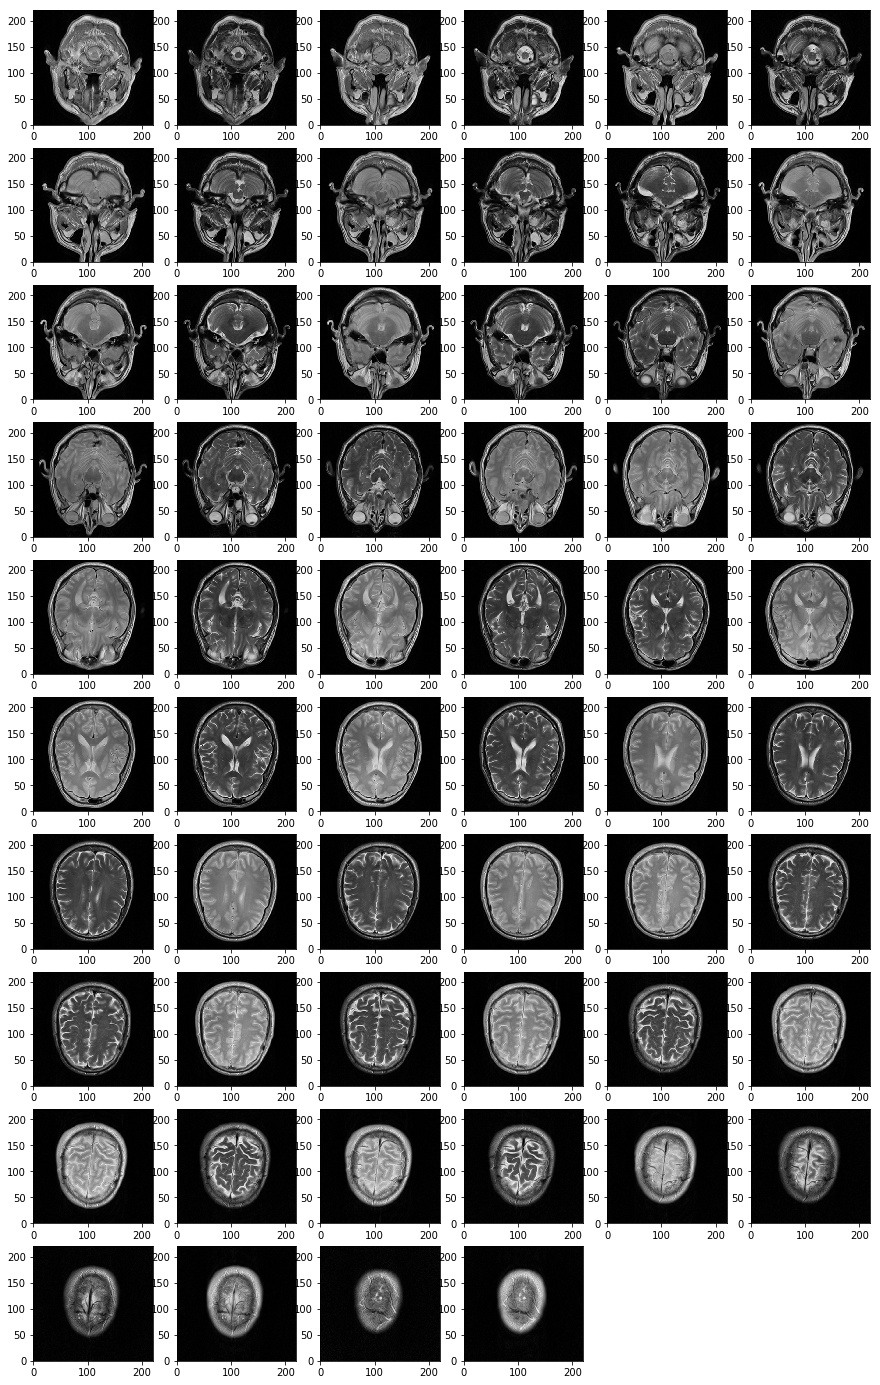

In [56]:
view_patient(file3)

NEW PATIENT
HAS PARKINSONS:  False
getting image for ...  ../ppmi/cd-pd/PPMI/3767/Axial_PD-T2_TSE/2013-01-16_09_06_28.0/S181440
getting x, y, z vals
SIZE:  (256, 228, 96)


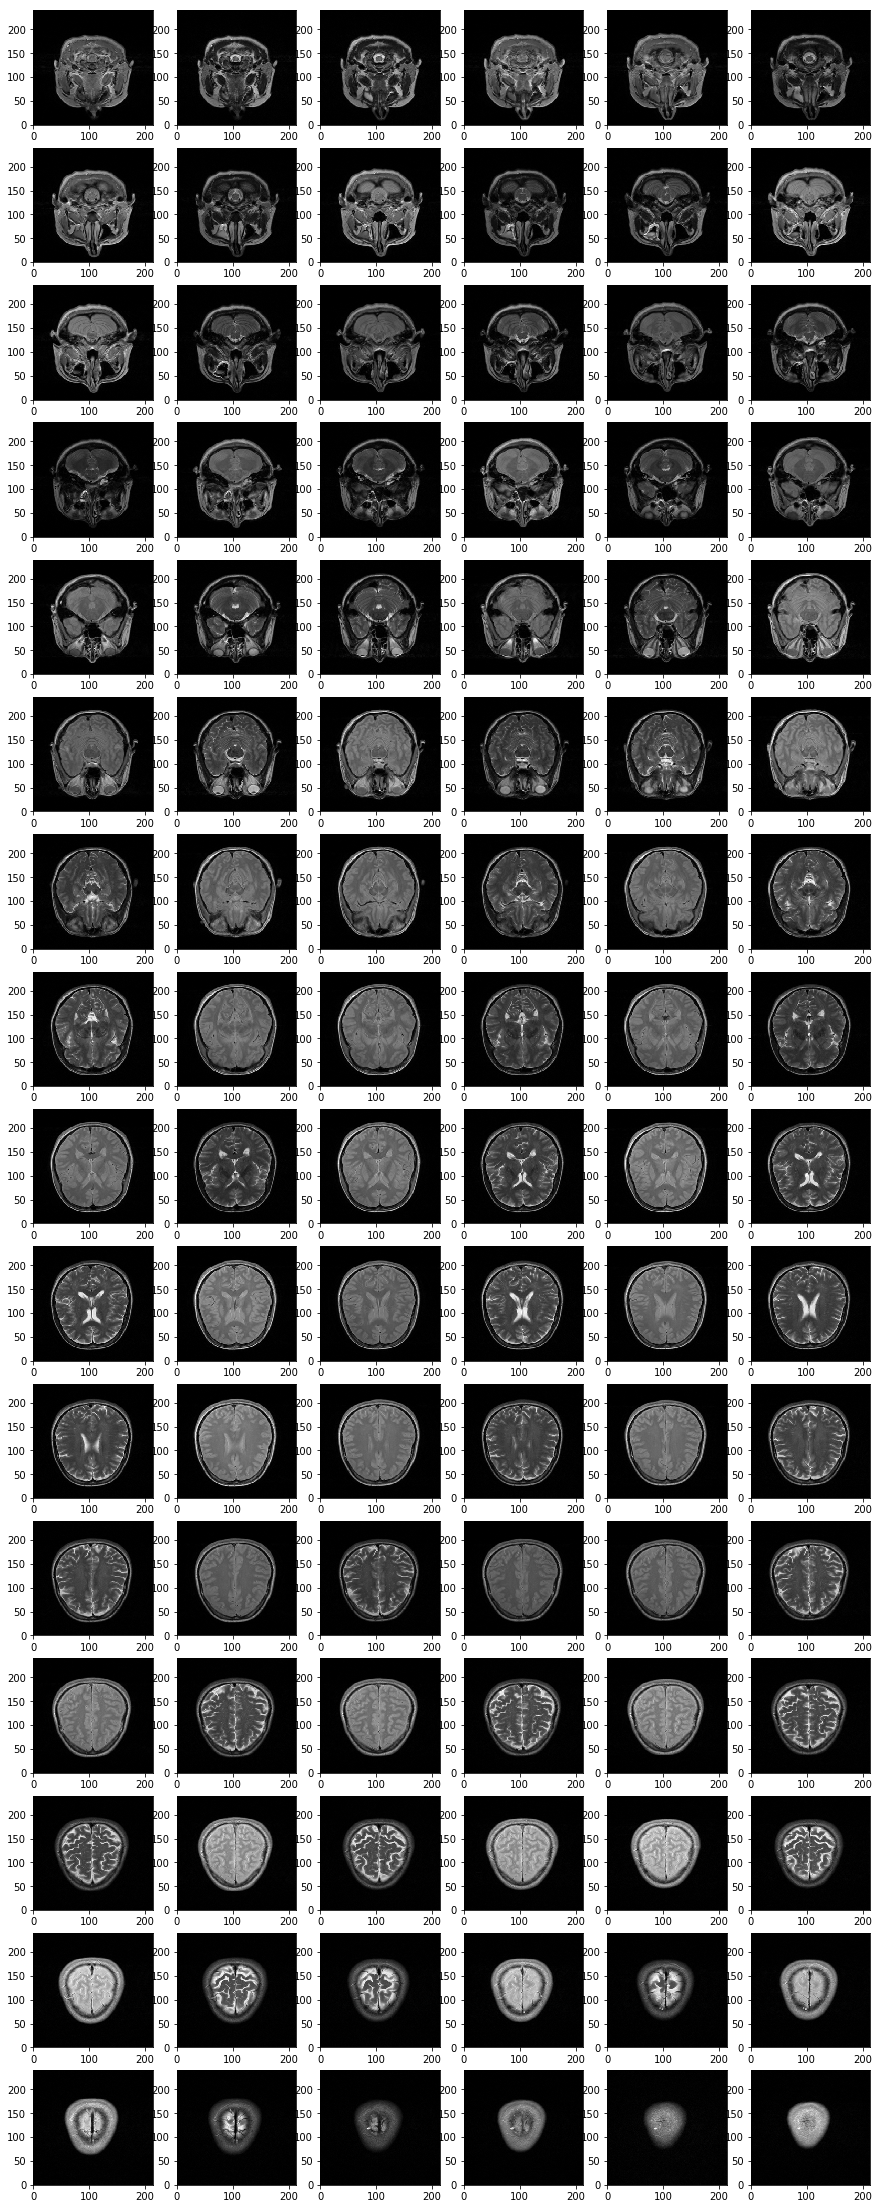

In [57]:
view_patient(file2)

In [52]:
def get_image_shapes(path_dict, path_y):
    image_shapes = {}
    new_dcm = []
    new_Y = []
    new_image_shapes = {}
    for i, file in enumerate(path_dict):
#         print(i, file)
        p1 = path_dict[file]

        RefDs = pydicom.read_file(p1[0])

        ConstPixelDims = (int(RefDs.Rows), int(RefDs.Columns), len(p1))

        try:

            ConstPixelSpacing = (float(RefDs.PixelSpacing[0]),
                                 float(RefDs.PixelSpacing[1]),
                                 float(RefDs.SliceThickness))

            x = np.arange(0.0, (ConstPixelDims[0]+1)*
                       ConstPixelSpacing[0], ConstPixelSpacing[0])
            y = np.arange(0.0, (ConstPixelDims[1]+1)*
                           ConstPixelSpacing[1], ConstPixelSpacing[1])
            z = np.arange(0.0, (ConstPixelDims[2]+1)*
                           ConstPixelSpacing[2], ConstPixelSpacing[2])

            ArrayDicom = np.zeros(ConstPixelDims, dtype=RefDs.pixel_array.dtype)

            image_shapes[i] = ArrayDicom.shape

            if ArrayDicom.shape[2] > 50:
                new_dcm.append(file)
                new_Y.append(path_y[file])
                new_image_shapes[file] = ArrayDicom.shape


        except:
            continue
    return image_shapes, new_dcm, new_Y, new_image_shapes

In [53]:
dcm_shapes, new_dcm, new_dcm_ys, new_dcm_shapes = get_image_shapes(dcm_dict, dcm_ys)

In [55]:
new_dcm_shapes

{'../ppmi/cd-pd/PPMI/3220/Ax_T2_FLAIR/2011-12-01_07_26_14.0/S139712': (256,
  256,
  58),
 '../ppmi/cd-pd/PPMI/3111/Axial_PD-T2_TSE/2011-05-26_13_20_29.0/S113786': (228,
  256,
  96),
 '../ppmi/cd-pd/PPMI/3230/Ax_T2_FLAIR/2012-07-18_10_28_29.0/S189279': (512,
  512,
  59),
 '../ppmi/cd-pd/PPMI/3320/Axial_PD-T2_TSE_AC_PC_line/2012-05-31_14_08_42.0/S157091': (256,
  228,
  96),
 '../ppmi/cd-pd/PPMI/3459/sT2W_PD_TSE/2011-05-16_14_29_13.0/S128037': (240,
  240,
  58),
 '../ppmi/cd-pd/PPMI/3472/sT2W_PD_TSE/2012-06-19_11_06_16.0/S158352': (240,
  240,
  58),
 '../ppmi/cd-pd/PPMI/3851/Axial_PD-T2_TSE_FS/2013-04-12_08_51_45.0/S203201': (256,
  228,
  108),
 '../ppmi/cd-pd/PPMI/3851/Axial_PD-T2_TSE/2011-04-13_08_18_19.0/S204362': (256,
  228,
  96),
 '../ppmi/cd-pd/PPMI/3360/Axial_PD-T2_TSE_FS/2015-04-29_08_32_35.0/S264321': (256,
  228,
  108),
 '../ppmi/cd-pd/PPMI/3360/Axial_PD-T2_TSE_FS/2013-07-31_08_57_43.0/S203304': (228,
  256,
  108),
 '../ppmi/cd-pd/PPMI/3360/Axial_PD-T2_TSE/2012-06-07_

In [44]:
dcm_stage_shapes, new_dcm_stage, new_dcm_y, new_dcm_shapes = get_image_shapes(dcm_stage_scans, dcm_stage_ys)

In [43]:
len(set(dcm_shapes.values())) , len(set(new_dcm_shapes.values()))

(97, 57)

In [44]:
len(dcm_dict), len(new_dcm), len(dcm_ys), len(new_dcm_ys)

(874, 665, 874, 665)

In [58]:
def make_X_flat(new_dcm, y):
    X = []
    Y = []
    paths = []
    for i, filepath in enumerate(new_dcm):
        pt = []
        dcm_files = dcm_dict[filepath]

        temp = []
        for file in dcm_files:
            ds = pydicom.read_file(file)
            temp.append(ds)

        temp = sorted(temp, key=lambda d: d.SliceLocation)
        temp = temp[:50]
        

        for ds in temp:
            arr = ds.pixel_array
            new = cv2.resize(arr, dsize=(256, 256), interpolation=cv2.INTER_CUBIC)
            X.append(new)
            Y.append(y[i])
            paths.append(filepath)
        print(i, filepath, y[i])

    return X, Y, paths

In [59]:
dcm_X, dcm_Y, dcm_paths = make_X_flat(new_dcm, new_dcm_ys)

0 ../ppmi/cd-pd/PPMI/3220/Ax_T2_FLAIR/2011-12-01_07_26_14.0/S139712 1
1 ../ppmi/cd-pd/PPMI/3111/Axial_PD-T2_TSE/2011-05-26_13_20_29.0/S113786 1
2 ../ppmi/cd-pd/PPMI/3230/Ax_T2_FLAIR/2012-07-18_10_28_29.0/S189279 1
3 ../ppmi/cd-pd/PPMI/3320/Axial_PD-T2_TSE_AC_PC_line/2012-05-31_14_08_42.0/S157091 0
4 ../ppmi/cd-pd/PPMI/3459/sT2W_PD_TSE/2011-05-16_14_29_13.0/S128037 1
5 ../ppmi/cd-pd/PPMI/3472/sT2W_PD_TSE/2012-06-19_11_06_16.0/S158352 1
6 ../ppmi/cd-pd/PPMI/3851/Axial_PD-T2_TSE_FS/2013-04-12_08_51_45.0/S203201 0
7 ../ppmi/cd-pd/PPMI/3851/Axial_PD-T2_TSE/2011-04-13_08_18_19.0/S204362 0
8 ../ppmi/cd-pd/PPMI/3360/Axial_PD-T2_TSE_FS/2015-04-29_08_32_35.0/S264321 1
9 ../ppmi/cd-pd/PPMI/3360/Axial_PD-T2_TSE_FS/2013-07-31_08_57_43.0/S203304 1
10 ../ppmi/cd-pd/PPMI/3360/Axial_PD-T2_TSE/2012-06-07_08_12_12.0/S157069 1
11 ../ppmi/cd-pd/PPMI/3360/Axial_PD-T2_TSE/2011-04-18_10_52_24.0/S117963 1
12 ../ppmi/cd-pd/PPMI/3957/Ax_PD__T2/2012-06-27_08_23_57.0/S184909 1
13 ../ppmi/cd-pd/PPMI/3586/Axial_PD-T

108 ../ppmi/cd-pd/PPMI/3601/AX_PD_+_T2/2011-03-24_13_10_07.0/S102937 1
109 ../ppmi/cd-pd/PPMI/3020/AX_T2_AC-PC_line_Entire_Brain/2012-04-21_11_15_54.0/S148895 1
110 ../ppmi/cd-pd/PPMI/3479/sT2W_PD_TSE/2013-01-02_10_17_24.0/S183660 0
111 ../ppmi/cd-pd/PPMI/3301/Axial_PD-T2_TSE_AC_PC_line/2012-02-16_16_23_16.0/S149021 0
112 ../ppmi/cd-pd/PPMI/3301/Axial_PD-T2_TSE_FS/2013-04-18_11_16_15.0/S193455 0
113 ../ppmi/cd-pd/PPMI/3301/Axial_PD-T2_TSE_FS/2015-03-18_13_18_54.0/S264315 0
114 ../ppmi/cd-pd/PPMI/3218/Ax_T2_FLAIR/2011-10-17_12_12_29.0/S139706 1
115 ../ppmi/cd-pd/PPMI/3012/AX_T2_AC-PC_line_Entire_Brain/2011-11-22_15_42_05.0/S147144 1
116 ../ppmi/cd-pd/PPMI/3471/sT2W_PD_TSE/2012-02-28_13_04_49.0/S170951 1
117 ../ppmi/cd-pd/PPMI/4011/AXIAL_PD-T2_TSE_FS/2016-02-11_10_55_58.0/S446253 1
118 ../ppmi/cd-pd/PPMI/4011/Axial_PD-T2_TSE_FS/2014-01-16_10_02_19.0/S212799 1
119 ../ppmi/cd-pd/PPMI/4011/Axial_PD-T2_TSE_FS/2012-12-06_11_17_43.0/S208540 1
120 ../ppmi/cd-pd/PPMI/3328/Axial_PD-T2_TSE_AC_PC_l

214 ../ppmi/cd-pd/PPMI/3779/Axial_PD-T2_TSE/2012-06-13_09_30_57.0/S160423 0
215 ../ppmi/cd-pd/PPMI/3800/Axial_PD-T2_TSE_FS/2013-03-19_11_35_35.0/S203323 1
216 ../ppmi/cd-pd/PPMI/3800/Axial_PD-T2_TSE_FS/2015-04-21_11_08_44.0/S263096 1
217 ../ppmi/cd-pd/PPMI/3800/Axial_PD-T2_TSE/2011-03-15_12_35_25.0/S131535 1
218 ../ppmi/cd-pd/PPMI/3203/Ax_T2_FLAIR/2011-01-06_12_34_23.0/S101871 1
219 ../ppmi/cd-pd/PPMI/3006/AX_T2_AC-PC_line_Entire_Brain/2011-05-10_17_47_53.0/S113521 1
220 ../ppmi/cd-pd/PPMI/3835/Axial_PD-T2_TSE_FS/2017-01-31_11_34_11.0/S648866 1
221 ../ppmi/cd-pd/PPMI/3835/Axial_PD-T2_TSE_FS/2014-01-28_10_57_14.0/S213521 1
222 ../ppmi/cd-pd/PPMI/3835/Axial_PD-T2_TSE_FS/2015-02-03_11_01_04.0/S250434 1
223 ../ppmi/cd-pd/PPMI/3835/Axial_PD-T2_TSE/2013-01-22_11_37_46.0/S189949 1
224 ../ppmi/cd-pd/PPMI/3216/Ax_T2_FLAIR/2011-08-26_10_09_54.0/S139703 0
225 ../ppmi/cd-pd/PPMI/3668/PD-T2_DUAL_AXIAL_TSE/2013-05-09_10_33_23.0/S189288 0
226 ../ppmi/cd-pd/PPMI/3660/PD-T2_DUAL_AXIAL_TSE/2012-03-16_08

320 ../ppmi/cd-pd/PPMI/4034/Axial_PD-T2_TSE_FS/2014-03-24_09_46_03.0/S217923 1
321 ../ppmi/cd-pd/PPMI/4034/Axial_PD-T2_TSE_FS/2013-04-02_09_57_23.0/S187109 1
322 ../ppmi/cd-pd/PPMI/3209/Ax_T2_FLAIR/2011-07-27_11_12_00.0/S189262 1
323 ../ppmi/cd-pd/PPMI/3260/AX_T2_DE/2011-05-27_10_45_19.0/S113542 0
324 ../ppmi/cd-pd/PPMI/3215/Ax_T2_FSE/2011-08-18_13_40_02.0/S190599 0
325 ../ppmi/cd-pd/PPMI/3221/Ax_T2_FLAIR/2011-12-08_08_11_59.0/S139716 0
326 ../ppmi/cd-pd/PPMI/3221/Axial_PD-T2_TSE_FS/2016-06-16_13_29_42.0/S484604 0
327 ../ppmi/cd-pd/PPMI/3819/Axial_PD-T2_TSE_FS/2014-03-25_10_35_33.0/S228224 1
328 ../ppmi/cd-pd/PPMI/3819/Axial_PD-T2_TSE_FS/2016-04-12_11_09_01.0/S426416 1
329 ../ppmi/cd-pd/PPMI/3819/Axial_PD-T2_TSE_FS/2013-04-09_10_03_54.0/S204519 1
330 ../ppmi/cd-pd/PPMI/3819/Axial_PD-T2_TSE/2012-04-17_11_36_16.0/S151346 1
331 ../ppmi/cd-pd/PPMI/3182/Axial_PD-T2-FS_TSE/2016-08-19_10_46_59.0/S501584 1
332 ../ppmi/cd-pd/PPMI/3182/Axial_PD-T2_TSE/2013-07-19_11_08_16.0/S203265 1
333 ../ppmi/

428 ../ppmi/cd-pd/PPMI/3174/Axial_PD-T2-FS_TSE/2014-04-15_11_20_27.0/S221706 1
429 ../ppmi/cd-pd/PPMI/3174/Axial_PD-T2_TSE/2012-04-12_10_45_48.0/S151264 1
430 ../ppmi/cd-pd/PPMI/3174/Axial_PD-T2_TSE/2013-04-09_10_58_50.0/S188380 1
431 ../ppmi/cd-pd/PPMI/3357/Axial_PD-T2_TSE_FS/2015-08-19_09_38_22.0/S277078 0
432 ../ppmi/cd-pd/PPMI/3357/Axial_PD-T2_TSE/2011-03-24_08_10_02.0/S117957 0
433 ../ppmi/cd-pd/PPMI/3357/Axial_PD-T2_TSE/2012-03-19_11_57_34.0/S146650 0
434 ../ppmi/cd-pd/PPMI/4082/Axial_PD-T2_TSE_FS/2014-03-11_08_57_35.0/S217935 1
435 ../ppmi/cd-pd/PPMI/4082/Axial_PD-T2_TSE_FS/2013-01-21_13_34_00.0/S181391 1
436 ../ppmi/cd-pd/PPMI/4082/Axial_PD-T2_TSE_FS/2017-02-20_13_22_36.0/S606343 1
437 ../ppmi/cd-pd/PPMI/4082/Axial_PD-T2_TSE_FS/2015-02-23_07_32_03.0/S308755 1
438 ../ppmi/cd-pd/PPMI/3664/PD-T2_DUAL_AXIAL_TSE/2013-02-25_11_28_17.0/S184908 1
439 ../ppmi/cd-pd/PPMI/3134/Axial_PD-T2_TSE_FS/2013-04-22_09_22_01.0/S188146 1
440 ../ppmi/cd-pd/PPMI/3134/Axial_PD-T2_TSE_FS/2017-04-14_12_1

535 ../ppmi/cd-pd/PPMI/3270/AX_T2_DE/2011-09-16_12_45_44.0/S124921 0
536 ../ppmi/cd-pd/PPMI/4136/Axial_PD-T2_TSE_FS/2014-05-06_13_49_47.0/S225642 1
537 ../ppmi/cd-pd/PPMI/4136/Axial_PD-T2_TSE_FS/2013-02-28_08_50_55.0/S193239 1
538 ../ppmi/cd-pd/PPMI/3201/Ax_T2_FLAIR/2010-12-02_10_58_37.0/S101956 0
539 ../ppmi/cd-pd/PPMI/3824/Axial_PD-T2_TSE_FS/2014-08-26_10_54_49.0/S234753 1
540 ../ppmi/cd-pd/PPMI/3824/Axial_PD-T2_TSE_FS/2016-08-23_11_13_39.0/S510971 1
541 ../ppmi/cd-pd/PPMI/3824/Axial_PD-T2_TSE/2013-09-03_12_17_39.0/S204631 1
542 ../ppmi/cd-pd/PPMI/3824/Axial_PD-T2_TSE/2012-07-10_10_59_51.0/S171123 1
543 ../ppmi/cd-pd/PPMI/3175/Axial_PD-T2-FS_TSE/2014-04-23_10_13_18.0/S221707 1
544 ../ppmi/cd-pd/PPMI/3175/Axial_PD-T2-FS_TSE/2016-08-24_10_47_33.0/S501573 1
545 ../ppmi/cd-pd/PPMI/3175/Axial_PD-T2_TSE/2012-04-18_10_40_04.0/S148978 1
546 ../ppmi/cd-pd/PPMI/3175/Axial_PD-T2_TSE/2013-05-10_10_55_48.0/S191155 1
547 ../ppmi/cd-pd/PPMI/3237/Ax_T2_FSE/2013-04-23_12_22_40.0/S190622 0
548 ../ppmi

642 ../ppmi/cd-pd/PPMI/3001/AX_T2_AC-PC_line_Entire_Brain/2011-03-02_11_28_01.0/S102127 1
643 ../ppmi/cd-pd/PPMI/3812/Axial_PD-T2_TSE/2012-09-25_11_19_18.0/S169270 0
644 ../ppmi/cd-pd/PPMI/3964/Ax_PD__T2/2013-01-31_08_13_58.0/S184919 1
645 ../ppmi/cd-pd/PPMI/3469/sT2W_PD_TSE/2012-02-07_11_00_13.0/S142361 1
646 ../ppmi/cd-pd/PPMI/3468/sT2W_PD_TSE/2012-02-07_12_27_58.0/S142358 0
647 ../ppmi/cd-pd/PPMI/3125/Axial_PD-T2_TSE_FS/2016-07-27_11_47_09.0/S493612 1
648 ../ppmi/cd-pd/PPMI/3125/Axial_PD-T2_TSE_FS/2013-07-10_09_47_17.0/S199138 1
649 ../ppmi/cd-pd/PPMI/3125/Axial_PD-T2_TSE_FS/2014-07-16_09_59_29.0/S228119 1
650 ../ppmi/cd-pd/PPMI/3125/Axial_PD-T2_TSE/2012-07-11_09_15_26.0/S169328 1
651 ../ppmi/cd-pd/PPMI/3252/AX_T2_DE/2011-01-13_07_39_48.0/S101967 1
652 ../ppmi/cd-pd/PPMI/3383/Axial_PD-T2_TSE_FS/2012-10-10_09_58_42.0/S177367 1
653 ../ppmi/cd-pd/PPMI/3383/Axial_PD-T2_TSE_FS/2016-10-12_08_15_45.0/S526766 1
654 ../ppmi/cd-pd/PPMI/3383/Axial_PD-T2_TSE_FS/2013-11-18_09_51_54.0/S213506 1
6

In [65]:
X = np.array(dcm_X)
Y = np.array(dcm_Y)
X = X.reshape(-1, 256, 256, 1)

In [66]:
X.shape, Y.shape

((33250, 256, 256, 1), (33250,))

In [118]:
dcms = {'X': new_dcm, 'Y': new_dcm_ys}
with open('dcm_scans_filtered.pickle', 'wb') as handle:
    pickle.dump(dcms, handle)
print(len(new_dcm), len(new_dcm_ys))

665 665


In [45]:
len(new_dcm_ys), sum(new_dcm_ys)

(665, 464)

In [45]:
dcms = {'X': new_dcm_stage, 'Y': new_dcm_y}
with open('dcm_stage_scans_filtered.pickle', 'wb') as handle:
    pickle.dump(dcms, handle)
print(len(new_dcm), len(new_dcm_ys))

665 665
